In [1]:
import lightgbm


import boruta

import sklearn.feature_selection as fs

import numpy as np

import fri
from sklearn.preprocessing import scale

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [3]:
def get_truth_AR(d, informative, redundant):
    truth = (
        [2] * (informative) + [1] * (redundant) + [0] * (d - (informative + redundant))
    )
    return truth


def get_truth(d, informative, redundant):
    truth = [True] * (informative + redundant) + [False] * (
        d - (informative + redundant)
    )
    return truth


from sklearn.metrics import precision_score, recall_score, f1_score


def get_scores(support, truth):
    return [
        (sc.__name__, sc(truth, support))
        for sc in [precision_score, recall_score, f1_score]
    ]


import sklearn.feature_selection as fs


def get_fs(estimator, X=None, y=None):
    fset = fs.SelectFromModel(
        prefit=True, estimator=estimator, threshold="mean"
    ).get_support()
    # fset = fs.RFECV(estimator=estimator,cv=3).fit(X,y).get_support()
    return fset


def RF(X, y, params=None):
    if params is None:
        lm = lightgbm.LGBMClassifier(
            max_depth=3, boosting_type="rf", bagging_fraction=0.632, bagging_freq=1,
        )
    else:
        lm = lightgbm.LGBMClassifier(**params)
    lm.fit(X, y)
    return lm


def get_MR(X, y, params=None):
    lm = RF(X, y, params)
    # todo: welcher score?
    score = lm.score(X, y)
    fset = get_fs(lm, X, y)
    fset = np.where(fset)
    return fset[0], score


def get_AR_params(X, y, params):
    tree_params = {k: v for k, v in params.items() if not k.startswith("b_")}
    boruta_params = {k[2:]: v for k, v in params.items() if k.startswith("b_")}

    lm = lightgbm.LGBMClassifier(**tree_params)
    feat_selector = BorutaPy(lm, verbose=0, random_state=1, **boruta_params)
    feat_selector.fit(X, y)

    fset = feat_selector.support_

    return fset

In [4]:
from sklearn.model_selection import ParameterGrid

best_params_rf = {
    "max_depth": [5],
    "boosting_type": ["rf"],
    "bagging_fraction": [0.632],
    "bagging_freq": [1],
    "feature_fraction": [0.1],
    "b_perc": [100],
    "b_n_estimators": ["auto"],
    "b_alpha": [0.01],
    "b_max_iter": [50],
    "importance_type": ["gain"],
}
best_params_rf = ParameterGrid(best_params_rf)[0]

In [5]:
best_params_boost = {
    "boosting_type": ["gbdt"],
}
best_params_boost = ParameterGrid(best_params_boost)[0]

# Iterative check

In [6]:
from sklearn.model_selection import cross_val_score

In [7]:
def create_support_AR(d, S, W):
    sup = np.zeros(d)
    sup[S] = 2
    sup[W] = 1
    return sup.astype(int)


def cv_score(X, y, model, cv=20):
    return np.mean(cross_val_score(model, X, y, cv=cv))


def train_and_score(X, y, params=None):
    rf = RF(X, y, params)
    return cv_score(X, y, rf)


def train_and_score_and_imps(X, y, params=None):
    rf = RF(X, y, params)
    return cv_score(X, y, rf), rf.feature_importances_


def score_with_feature_set(X, y, featureset: list, params=None):
    return train_and_score(X[:, featureset], y, params)


def score_and_imps_with_feature_set(X, y, featureset: list, params=None):
    return train_and_score_and_imps(X[:, featureset], y, params)


def sort_features(X, y, MR, AR, params_rf=None, params_boost=None):
    S = []
    W = list(np.setdiff1d(AR, MR))
    print(f"predetermined weakly {W}")

    score_on_MR = score_with_feature_set(X, y, MR, params_boost)
    score_on_AR = score_with_feature_set(X, y, AR, params_boost)
    MR_and_W = np.union1d(MR, W)
    score_on_MR_and_W = score_with_feature_set(X, y, MR_and_W, params_boost)
    scores = {"MR": score_on_MR, "AR": score_on_AR, "MR+W": score_on_MR_and_W}
    for k, sc in scores.items():
        print(f"{k} has score {sc}")
    diffs = np.zeros(len(MR))

    len_MR = len(MR)
    len_W = len(W)
    n_features = len_MR + len_W
    imps = np.zeros((len_MR,X.shape[1]))

    for i, f in enumerate(MR):

        C = np.setdiff1d(MR, f)  # Remove f from minimal set
        C = np.union1d(C, W)  # Combine with weakly relevant features
        C = sorted(C)
        print(C)
        
        score_c, imps_c = score_and_imps_with_feature_set(X, y, C, params_boost)
        imps[i,C] = imps_c
        imps[i,i] = np.mean(imps_c)
        print(f"score without {f} is {score_c:.3}-> ", end="")

        diffs[i] = score_on_MR_and_W - score_c

        if score_c < score_on_MR_and_W:
            print(f"S")
            S.append(f)
        else:
            print(f"W")
            W.append(f)
    return create_support_AR(X.shape[1], S, W), diffs,imps


def get_ar_classes(X, y, params_rf, params_boost):

    AR = np.where(get_AR_params(X, y, params_rf))[0]
    MR, score = get_MR(X, y, params_boost)

    print(f"Features from Boruta:\n {AR}")
    print(f"Features from Lightbgm:\n {MR}")

    return sort_features(X, y, MR, AR, params_rf, params_boost)

In [8]:
informative = 10
redundant = 4
d = 50

X, y = fri.genClassificationData(
    n_features=d,
    n_redundant=redundant,
    n_strel=informative,
    n_samples=400,
    random_state=123,
)
X = scale(X)

truth = get_truth(d, informative, redundant)
truth_AR = get_truth_AR(d, informative, redundant)

In [9]:
predict_AR, diffs,imps = get_ar_classes(X, y, best_params_rf, best_params_boost)

Features from Boruta:
 [ 0  1  2  3  4  5  7  8  9 10 11 12]
Features from Lightbgm:
 [ 0  1  2  3  4  5  6  7  8  9 12 20 25]
predetermined weakly [10, 11]
MR has score 0.8606015037593986
AR has score 0.8583646616541353
MR+W has score 0.8658395989974939
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 0 is 0.823-> S
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 1 is 0.832-> S
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 2 is 0.836-> S
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 3 is 0.812-> S
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 4 is 0.817-> S
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 20, 25]
score without 5 is 0.816-> S
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 20, 25]
score without 6 is 0.856-> S
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 20, 25]
score without 7 is 0.836-> S
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 20, 25]
score without 8 is 0.816-> S
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 20, 25]
scor

In [13]:

imps

array([[103.28571429, 150.        , 132.        , 115.        ,
        137.        , 135.        , 102.        , 127.        ,
        151.        , 146.        ,  42.        ,  36.        ,
         63.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         71.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  39.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [122.        , 102.        , 115.        , 128.        ,
        150.        , 115.        ,  98.        , 149.        ,
        152.        , 124.        ,  46.        ,  54.        ,
   

In [14]:
imps[0]-imps.mean(0)

array([-24.58241758,  17.76923077,  10.23626374,  -2.29120879,
         3.47802198,  10.66483516,   0.93406593, -11.29120879,
        17.1978022 ,  15.23076923,  -4.96153846, -13.71978022,
        -0.35714286,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        14.84615385,   0.        ,   0.        ,   0.        ,
         0.        , -11.07692308,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [15]:
imps.mean(0)

array([127.86813187, 132.23076923, 121.76373626, 117.29120879,
       133.52197802, 124.33516484, 101.06593407, 138.29120879,
       133.8021978 , 130.76923077,  46.96153846,  49.71978022,
        63.35714286,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        56.15384615,   0.        ,   0.        ,   0.        ,
         0.        ,  50.07692308,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

0.25


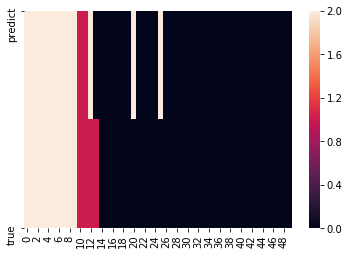

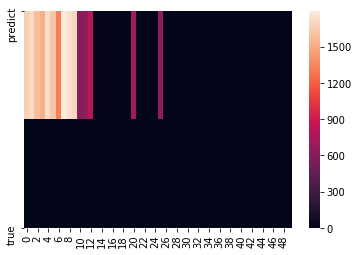

In [16]:
from scipy.spatial.distance import jaccard

jac = jaccard(predict_AR, truth_AR)
print(jac)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(np.array([predict_AR, truth_AR]), yticklabels=["predict", "true"])
plt.figure()
sns.heatmap(np.array([imps.sum(0), truth_AR]), yticklabels=["predict", "true"])

In [17]:
diffs

array([0.04303885, 0.03339599, 0.02986842, 0.05342105, 0.04865915,
       0.05028822, 0.01022556, 0.03003759, 0.04966792, 0.05252506,
       0.00763158, 0.0081203 , 0.01486842])

<BarContainer object of 13 artists>

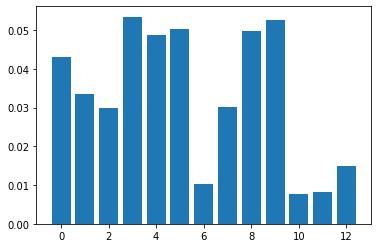

In [18]:
plt.bar(np.arange(len(diffs)), height=diffs)

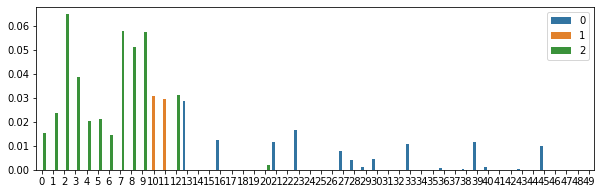

In [19]:
from sklearn.feature_selection import mutual_info_classif as mi
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
sns.barplot(y=mi(X, y, n_neighbors=50), x=np.arange(X.shape[1]), hue=predict_AR)

In [20]:
import squamish.plot

In [21]:
color = squamish.plot.get_colors(imps.shape[1],predict_AR)

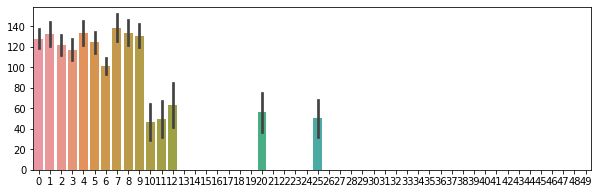

In [22]:
plt.figure(figsize=(10, 3))
sns.barplot(data=pd.DataFrame(imps),ci="sd")

In [27]:
frame=pd.DataFrame(imps)

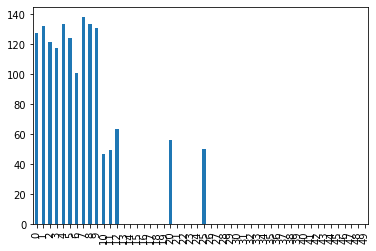

In [32]:
frame.mean().plot(kind="bar")

In [41]:
np.percentile(imps,[0,50,100],axis=0)

array([[103.28571429, 102.        , 102.92857143, 102.78571429,
        102.78571429, 102.35714286,  87.        , 101.78571429,
        102.42857143, 103.        ,  28.        ,  31.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [129.        , 131.        , 122.        , 116.        ,
        136.        , 125.        , 101.        , 140.        ,
        134.        , 132.        ,  45.        ,  47.        ,
   

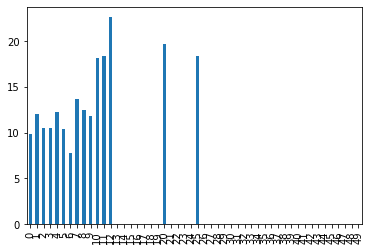

In [44]:
frame.std().plot(kind="bar")